In [1]:
!pip install imblearn

In [2]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query1 = '''
select r.rental_id, f.film_id, f.title, c.category_id, c.name, f.rating, substring(r.return_date, 1, 10) as return_date, f.rental_duration, f.rental_rate,
case when rental_date between '2005-08-01 00:00:00' and '2005-08-31 23:59:59' then 1 else 0 end as rented_next_month
from sakila.rental r join sakila.inventory using (inventory_id)
join sakila.film f using (film_id) 
join sakila.film_category using (film_id)
join sakila.category c using (category_id)
group by film_id order by film_id asc;
        '''

query2 = '''
select distinct count(f.film_id) as num_times_rented, f.film_id 
from sakila.film f join sakila.inventory i using (film_id)
join sakila.rental using (inventory_id)
where rental_date between '2005-06-01 00:00:00' and '2005-07-31 23:59:59'
group by film_id order by film_id asc;
        '''

df1 = pd.read_sql_query(query1, engine)
df2 = pd.read_sql_query(query2, engine)

In [4]:
df1

,rental_id,film_id,title,category_id,name,rating,return_date,rental_duration,rental_rate,rented_next_month
0,4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-11,6,0.99,0
1,10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-04,3,4.99,1
2,6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-29,7,2.99,0
3,6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-16,5,2.99,0
4,552,5,AFRICAN EGG,8,Family,G,2005-06-04,6,2.99,0
...,...,...,...,...,...,...,...,...,...,...
953,4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-12,6,0.99,0
954,7240,997,YOUTH KICK,12,Music,NC-17,2005-08-03,4,0.99,0
955,1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-21,6,0.99,0
956,3734,999,ZOOLANDER FICTION,3,Children,R,2005-07-14,5,2.99,0


In [5]:
df2

,num_times_rented,film_id
0,12,1
1,2,2
2,5,3
3,14,4
4,7,5
...,...,...
953,4,996
954,3,997
955,5,998
956,9,999


In [6]:
df3 = df1.merge(df2, how='right')
df3

,rental_id,film_id,title,category_id,name,rating,return_date,rental_duration,rental_rate,rented_next_month,num_times_rented
0,4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-11,6,0.99,0,12
1,10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-04,3,4.99,1,2
2,6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-29,7,2.99,0,5
3,6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-16,5,2.99,0,14
4,552,5,AFRICAN EGG,8,Family,G,2005-06-04,6,2.99,0,7
...,...,...,...,...,...,...,...,...,...,...,...
953,4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-12,6,0.99,0,4
954,7240,997,YOUTH KICK,12,Music,NC-17,2005-08-03,4,0.99,0,3
955,1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-21,6,0.99,0,5
956,3734,999,ZOOLANDER FICTION,3,Children,R,2005-07-14,5,2.99,0,9


In [7]:
data = df3[['rental_id', 'film_id', 'title', 'category_id', 'name', 'rating', 'return_date', 'rental_duration', 'rental_rate', 'num_times_rented', 'rented_next_month']]
data

,rental_id,film_id,title,category_id,name,rating,return_date,rental_duration,rental_rate,num_times_rented,rented_next_month
0,4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-11,6,0.99,12,0
1,10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-04,3,4.99,2,1
2,6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-29,7,2.99,5,0
3,6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-16,5,2.99,14,0
4,552,5,AFRICAN EGG,8,Family,G,2005-06-04,6,2.99,7,0
...,...,...,...,...,...,...,...,...,...,...,...
953,4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-12,6,0.99,4,0
954,7240,997,YOUTH KICK,12,Music,NC-17,2005-08-03,4,0.99,3,0
955,1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-21,6,0.99,5,0
956,3734,999,ZOOLANDER FICTION,3,Children,R,2005-07-14,5,2.99,9,0


# Our target variable will be rented_next_month (0-no or 1-yes), that corresponds with films rented during August 2005

In [8]:
data = data.set_index('rental_id')
data

,film_id,title,category_id,name,rating,return_date,rental_duration,rental_rate,num_times_rented,rented_next_month
rental_id,,,,,,,,,,
4863,1,ACADEMY DINOSAUR,6,Documentary,PG,2005-07-11,6,0.99,12,0
10310,2,ACE GOLDFINGER,11,Horror,G,2005-08-04,3,4.99,2,1
6999,3,ADAPTATION HOLES,6,Documentary,NC-17,2005-07-29,7,2.99,5,0
6493,4,AFFAIR PREJUDICE,11,Horror,G,2005-07-16,5,2.99,14,0
552,5,AFRICAN EGG,8,Family,G,2005-06-04,6,2.99,7,0
...,...,...,...,...,...,...,...,...,...,...
4969,996,YOUNG LANGUAGE,6,Documentary,G,2005-07-12,6,0.99,4,0
7240,997,YOUTH KICK,12,Music,NC-17,2005-08-03,4,0.99,3,0
1884,998,ZHIVAGO CORE,11,Horror,NC-17,2005-06-21,6,0.99,5,0


In [9]:
data.dtypes

film_id                int64
title                 object
category_id            int64
name                  object
rating                object
return_date           object
rental_duration        int64
rental_rate          float64
num_times_rented       int64
rented_next_month      int64
dtype: object

In [10]:
data.describe()

,film_id,category_id,rental_duration,rental_rate,num_times_rented,rented_next_month
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,8.483299,4.969729,2.977474,9.415449,0.086639
std,287.541738,4.615321,1.407593,1.643152,4.022228,0.281452
min,1.000000,1.000000,3.000000,0.990000,1.000000,0.000000
25%,256.250000,5.000000,4.000000,0.990000,6.000000,0.000000
50%,504.500000,8.000000,5.000000,2.990000,9.000000,0.000000
75%,751.750000,13.000000,6.000000,4.990000,12.000000,0.000000
max,1000.000000,16.000000,7.000000,4.990000,22.000000,1.000000


In [11]:
data.isna().sum()

film_id              0
title                0
category_id          0
name                 0
rating               0
return_date          0
rental_duration      0
rental_rate          0
num_times_rented     0
rented_next_month    0
dtype: int64

In [12]:
data['rented_next_month'].value_counts()

0    875
1     83
Name: rented_next_month, dtype: int64

In [13]:
data.corr(method='pearson')

,film_id,category_id,rental_duration,rental_rate,num_times_rented,rented_next_month
film_id,1.000000,0.000076,-0.037509,-0.031217,0.011700,-0.069873
category_id,0.000076,1.000000,0.009814,0.083196,-0.062331,-0.053988
rental_duration,-0.037509,0.009814,1.000000,0.030557,-0.054253,-0.035574
rental_rate,-0.031217,0.083196,0.030557,1.000000,-0.048224,0.015906
num_times_rented,0.011700,-0.062331,-0.054253,-0.048224,1.000000,-0.106594
rented_next_month,-0.069873,-0.053988,-0.035574,0.015906,-0.106594,1.000000


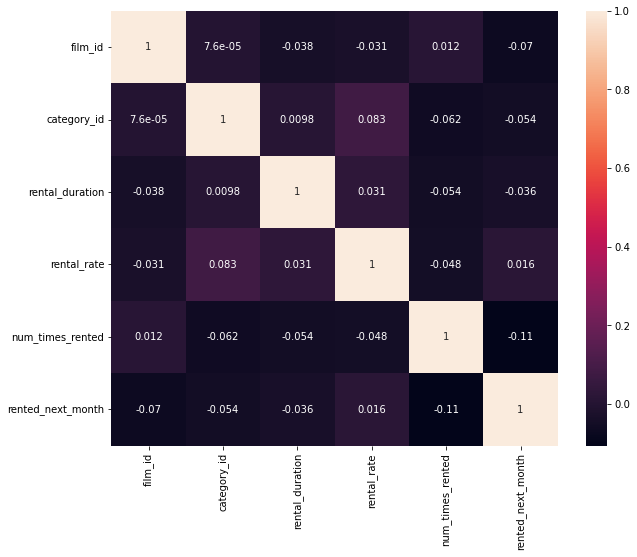

In [14]:
corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

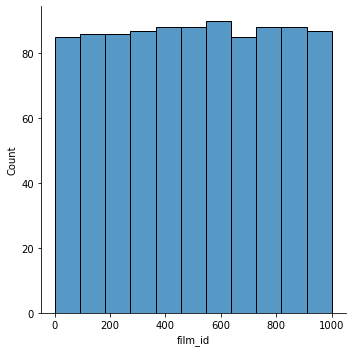

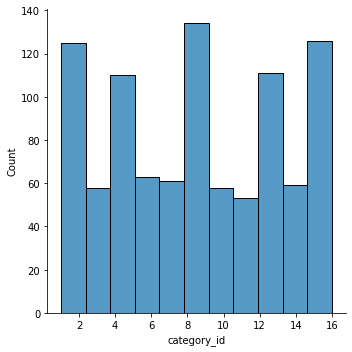

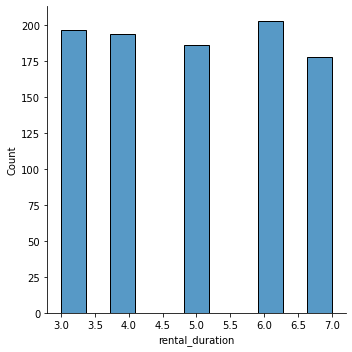

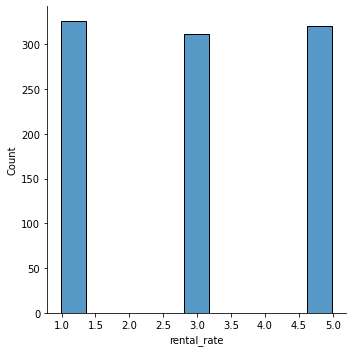

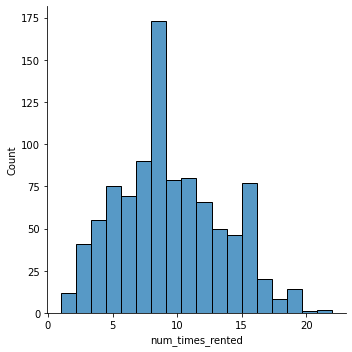

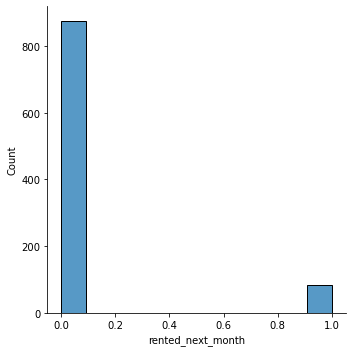

In [15]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [16]:
X = pd.get_dummies(data.drop('rented_next_month', axis=1))
y = data['rented_next_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       175
           1       0.86      0.35      0.50        17

    accuracy                           0.94       192
   macro avg       0.90      0.67      0.73       192
weighted avg       0.93      0.94      0.93       192



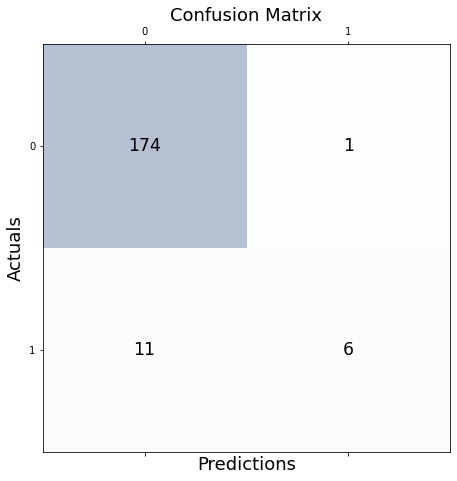

In [17]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# We have obtained very good results for the ones that are not going to be rented (0) next month (August 2005) maybe because the data is imbalanced, and we have instances of one of the two classes, 0 or No in this case, that is much higher than the other; in another way, the number of observations is not the same for both the classes in this classification dataset